# import

In [2]:
import torch
import numpy
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
import torch.nn.functional as F

# 데이터 셋 생성

In [3]:
n_dim = 2
x_train, y_train = make_blobs(n_samples=80, n_features=n_dim, 
                              centers=[[1,1],[-1,-1],[1,-1],[-1,1]], 
                              shuffle=True, cluster_std=0.3)
x_test, y_test = make_blobs(n_samples=20, n_features=n_dim,
                            centers=[[1,1],[-1,-1],[1,-1],[-1,1]], 
                            shuffle=True, cluster_std=0.3)

def label_map(y_, from_, to_):
    y = numpy.copy(y_)
    for f in from_:
        y[y_ == f] = to_
    return y

y_train = label_map(y_train, [0,1],0)
y_train = label_map(y_train, [2,3],1)
y_test = label_map(y_test, [0,1],0)
y_test = label_map(y_test, [2,3],1)

# 생성된 데이터 셋 시각화

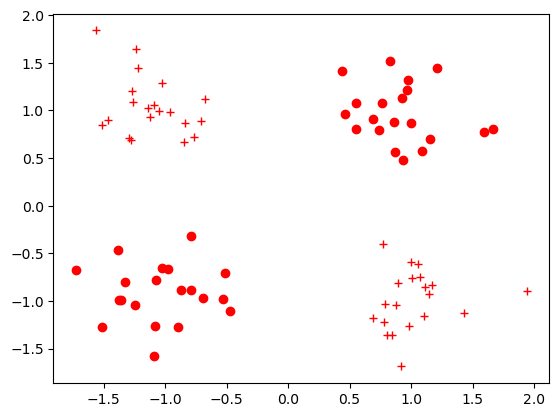

In [6]:
def vis_data(x, y = None, c = 'r'):
    if y is None:
        y = [None] * len(x)
    for x_, y_ in zip(x,y):
        if y_ is None:
            plt.plot(x_[0], x_[1], '+', markerfacecolor='none',
                     markeredgecolor=c)
        else:
            plt.plot(x_[0], x_[1], c+'o' if y_ == 0 else c+'+')

plt.figure()
vis_data(x_train, y_train, c='r')
plt.show()

# 데이터셋을 파이토치 텐서로 변환

In [7]:
x_train = torch.FloatTensor(x_train)
x_test = torch.FloatTensor(x_test)
y_train = torch.FloatTensor(y_train)
y_test = torch.FloatTensor(y_test)

# 신경망 모델 정의

In [15]:
class NeuralNet(torch.nn.Module):
    def __init__(self, input_size, hidden_size):
        super(NeuralNet, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.linear_1 = torch.nn.Linear(self.input_size, self.hidden_size)
        self.relu = torch.nn.ReLU()
        self.linear_2 = torch.nn.Linear(self.hidden_size, 1)
        self.sigmoid = torch.nn.Sigmoid()
        
    def forward(self, input_tensor):
        linear1 = self.linear_1(input_tensor)
        relu = self.relu(linear1)
        linear2 = self.linear_2(relu)
        output = self.sigmoid(linear2)
        return output

# 신경망 모델 생성 및 관련 변수와 알고리즘 정의

In [16]:
model = NeuralNet(2,5)
learning_rate = 0.3
criterion = torch.nn.BCELoss()
epochs = 2000
optimizer = torch.optim.SGD(model.parameters(),
                            lr = learning_rate)

# 학습 전 모델 성능 평가

In [19]:
model.eval()
test_loss_before = criterion(model(x_test).squeeze(), y_test)
print('Before Training, test loss is {}'.format(test_loss_before.item()))

Before Training, test loss is 0.7005239129066467


# 신경망 학습

In [21]:
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    train_output = model(x_train)
    train_loss = criterion(train_output.squeeze(), y_train)
    if epoch % 100 == 0:
        print('Train loss at {} is {}'.format(epoch, train_loss.item()))
    train_loss.backward()
    optimizer.step()

Train loss at 0 is 0.7073945999145508
Train loss at 100 is 0.08246468752622604
Train loss at 200 is 0.019450435414910316
Train loss at 300 is 0.010017517022788525
Train loss at 400 is 0.006550957914441824
Train loss at 500 is 0.0048037306405603886
Train loss at 600 is 0.00376114365644753
Train loss at 700 is 0.003073158673942089
Train loss at 800 is 0.002587581519037485
Train loss at 900 is 0.002228207653388381
Train loss at 1000 is 0.001952040591277182
Train loss at 1100 is 0.0017336125019937754
Train loss at 1200 is 0.0015568491071462631
Train loss at 1300 is 0.0014110845513641834
Train loss at 1400 is 0.0012889498611912131
Train loss at 1500 is 0.0011852136813104153
Train loss at 1600 is 0.0010961012449115515
Train loss at 1700 is 0.001018773065879941
Train loss at 1800 is 0.0009510867530480027
Train loss at 1900 is 0.0008913660421967506


# 학습 후 모델 성능 평가

In [22]:
model.eval()
test_loss = criterion(model(x_test).squeeze(), y_test)
print('After Training, test loss is {}'.format(test_loss.item()))

After Training, test loss is 0.0049323285929858685


# 학습된 가중치 저장

In [23]:
torch.save(model.state_dict(), './model.pt')
print('state_dict format of the model: {}'.format(model.state_dict()))

state_dict format of the model: OrderedDict([('linear_1.weight', tensor([[ 1.7596, -1.7501],
        [-0.0825, -0.0563],
        [-2.1669, -2.2103],
        [-1.7193,  1.8758],
        [ 2.0629,  2.3809]])), ('linear_1.bias', tensor([ 0.3299, -0.1898, -0.0073,  0.1138, -0.2370])), ('linear_2.weight', tensor([[ 2.3928,  0.0627, -2.9822,  2.4171, -3.1081]])), ('linear_2.bias', tensor([0.6424]))])


# 저장된 가중치를 불러와 새로운 모델에 적용(전이 학습)

In [24]:
new_model = NeuralNet(2,5)
new_model.load_state_dict(torch.load('./model.pt'))
new_model.eval()
print('벡터 [-1, 1]이 레이블 1을 가질 확률은 {}'.format(new_model(torch.FloatTensor([-1,1])).item()))

벡터 [-1, 1]이 레이블 1을 가질 확률은 0.9999135732650757
